In [25]:
%pip install pandas numpy scikit-learn sqlparse matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
import sqlparse
import sklearn
import matplotlib
import seaborn


print("All imports succeeded!")

All imports succeeded!


In [27]:
def analyze_sql(sql_text):
    sql = sqlparse.format(sql_text, reindent=True, keyword_case='lower')
    parsed = sqlparse.parse(sql)[0]
    tokens = [str(t).lower() for t in parsed.flatten()]

    keywords = ['select', 'join', 'where', 'group by', 'order by', 'having']
    counts = {k: 0 for k in keywords}

    for token in tokens:
        for k in keywords:
            if k in token:
                counts[k] += 1

    return counts


In [28]:
sample = """
SELECT name, salary 
FROM employees 
JOIN departments ON employees.dept_id = departments.id 
WHERE salary > 50000 
GROUP BY name 
ORDER BY salary DESC;
"""

analyze_sql(sample)



{'select': 1, 'join': 1, 'where': 1, 'group by': 1, 'order by': 1, 'having': 0}

In [29]:
import random

keywords = ['select', 'join', 'where', 'group by', 'order by', 'having']

def generate_fake_sql():
    sql = "SELECT * FROM table"
    ops = random.sample(keywords, k=random.randint(1, 4))
    sql += " " + " ".join(ops)
    return sql
    

sql_queries = [generate_fake_sql() for _ in range(100)]


query_data = []
for sql in sql_queries:
    features = analyze_sql(sql)
    total_ops = sum(features.values())
    runtime_ms = 50 + total_ops * 100 + random.randint(-30, 50)
    query_data.append({
        "sql": sql,
        "runtime_ms": runtime_ms,
        **features
    })

df = pd.DataFrame(query_data)


def label_runtime(ms):
    if ms < 150:
        return 'Fast'
    elif ms < 300:
        return 'Moderate'
    else:
        return 'Slow'

df['runtime_class'] = df['runtime_ms'].apply(label_runtime)


In [30]:
df = pd.DataFrame(query_data)
df

sql  runtime_ms  select  \
0                        SELECT * FROM table order by         280       1   
1             SELECT * FROM table where join order by         481       1   
2                 SELECT * FROM table select group by         390       2   
3           SELECT * FROM table having where group by         456       1   
4   SELECT * FROM table group by having join order by         581       1   
..                                                ...         ...     ...   
95     SELECT * FROM table where select group by join         581       2   
96   SELECT * FROM table where having group by select         546       2   
97                   SELECT * FROM table select where         351       2   
98                  SELECT * FROM table join order by         355       1   
99           SELECT * FROM table order by select join         426       2   

    join  where  group by  order by  having  
0      0      0         0         1       0  
1      1      1         0         1       0  
2      0      0         1         0       0  
3      0      1         1         0       1  
4      1      0         1         1       1  
..   ...    ...       ...       ...     ...  
95     1      1         1         0       0  
96     0      1         1         0       1  
97     0      1         0         0       0  
98     1      0         0         1       0  
99     1      0         0         1       0  

[100 rows x 8 columns]

In [31]:
from sklearn.model_selection import train_test_split


X = df[['select', 'join', 'where', 'group by', 'order by', 'having']]


y_reg = df['runtime_ms']


def label_runtime(ms):
    if ms < 150:
        return 'Fast'
    elif ms < 300:
        return 'Moderate'
    else:
        return 'Slow'

df['runtime_class'] = df['runtime_ms'].apply(label_runtime)
y_cls = df['runtime_class']


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.3, random_state=42)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

reg = RandomForestRegressor(n_estimators=100, random_state=0)
reg.fit(X_train_reg, y_train_reg)

y_pred_reg = reg.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print("Regression Results:")
print("RMSE:", rmse)
print("R²:", r2_score(y_test_reg, y_pred_reg))


Regression Results:
RMSE: 43.900079890202214
R²: 0.8363025943226129


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['select', 'join', 'where', 'group by', 'order by', 'having']]
y_cls = df['runtime_class']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_cls, y_train_cls)

y_pred_cls = clf.predict(X_test_cls)

print("Classification Results:")
print(classification_report(y_test_cls, y_pred_cls))


Classification Results:
              precision    recall  f1-score   support

    Moderate       0.57      1.00      0.73         4
        Slow       1.00      0.88      0.94        26

    accuracy                           0.90        30
   macro avg       0.79      0.94      0.83        30
weighted avg       0.94      0.90      0.91        30



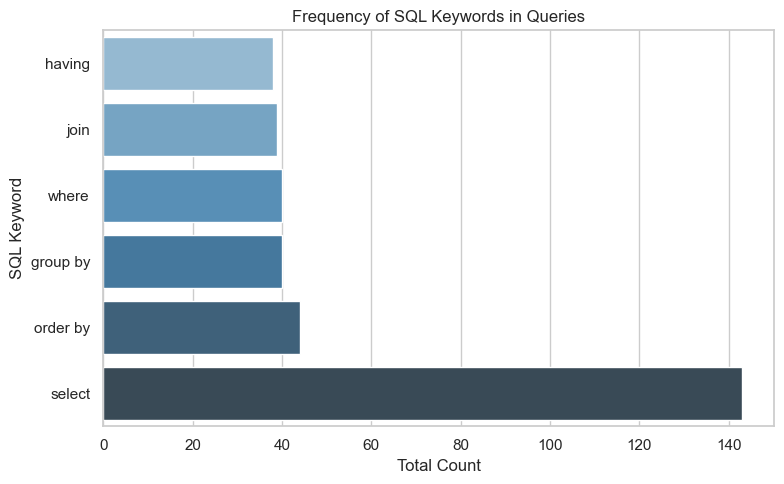

In [34]:
# DataFrame 
freq_df = keyword_sums.reset_index()
freq_df.columns = ['keyword', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(data=freq_df, x='count', y='keyword', hue='keyword', palette='Blues_d', dodge=False, legend=False)
plt.title("Frequency of SQL Keywords in Queries")
plt.xlabel("Total Count")
plt.ylabel("SQL Keyword")
plt.tight_layout()
plt.savefig("output/sql_keyword_frequency.png")
plt.show()


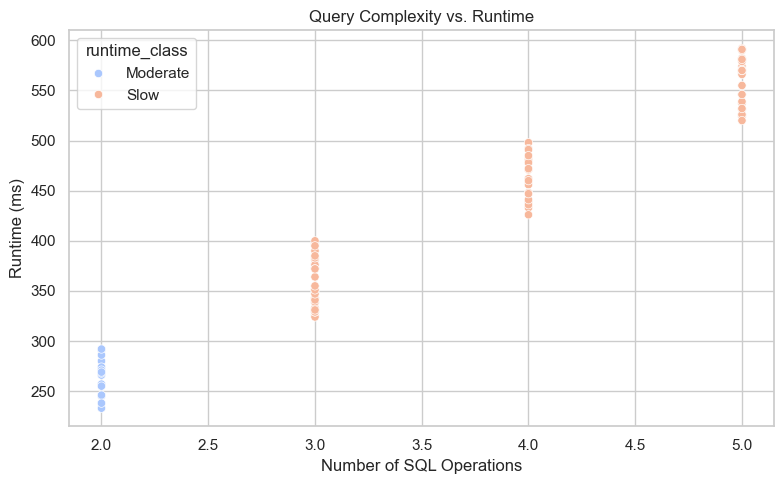

In [35]:
df['complexity'] = df[keyword_cols].sum(axis=1)

plt.figure(figsize=(8, 5))
sns.scatterplot(x='complexity', y='runtime_ms', hue='runtime_class', data=df, palette='coolwarm')
plt.title("Query Complexity vs. Runtime")
plt.xlabel("Number of SQL Operations")
plt.ylabel("Runtime (ms)")
plt.tight_layout()
plt.savefig("output/complexity_vs_runtime.png")
plt.show()



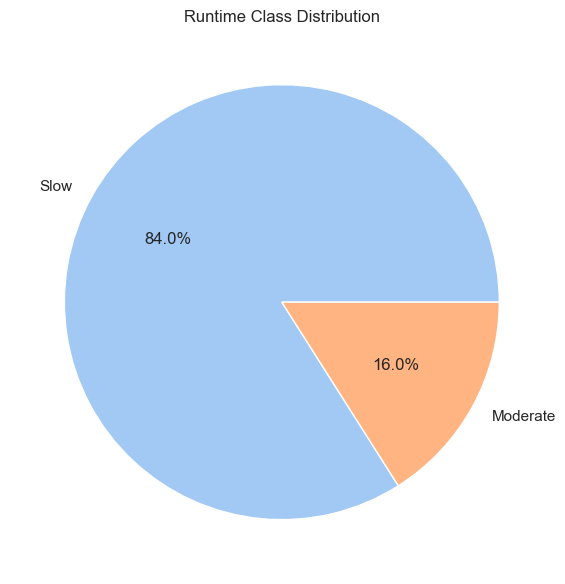

In [36]:
plt.figure(figsize=(6,6))
df['runtime_class'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Runtime Class Distribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig("output/class_distribution_pie.png")
plt.show()



In [37]:
import joblib


joblib.dump(reg, 'output/sql_runtime_regressor.pkl')

joblib.dump(clf, 'output/sql_runtime_classifier.pkl')


['output/sql_runtime_classifier.pkl']

In [38]:
def predict_sql_runtime(sql_text):
    features = analyze_sql(sql_text)
    X_new = pd.DataFrame([features])

    
    reg_model = joblib.load('output/sql_runtime_regressor.pkl')
    
    cls_model = joblib.load('output/sql_runtime_classifier.pkl')

    predicted_time = reg_model.predict(X_new)[0]
    predicted_class = cls_model.predict(X_new)[0]

    print("SQL Statement:")
    print(sql_text)
    print("Predicted Runtime (ms):", round(predicted_time, 2))
    print("Predicted Class:", predicted_class)

    return predicted_time, predicted_class


In [39]:
test_sql = "SELECT name FROM users JOIN orders ON users.id = orders.user_id WHERE orders.amount > 1000 ORDER BY orders.date DESC;"
predict_sql_runtime(test_sql)

SQL Statement:
SELECT name FROM users JOIN orders ON users.id = orders.user_id WHERE orders.amount > 1000 ORDER BY orders.date DESC;
Predicted Runtime (ms): 481.65
Predicted Class: Slow


(np.float64(481.65385714285713), 'Slow')

In [40]:
%pip install streamlit


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
